Note:  This notebook has widgets to select the state, congressional district and facility.  Those currently work only when the cells are run one at a time sequentially, not all at once.

## Clean Air Act Violations by Congressional District

This notebook examines ECHO data using ICIS-AIR_VIOLATION_HISTORY.
The HPV_DAYZERO_DATE reporting the start date of every episode of 
High Priority Violation (HPV) is used.  The PGM_SYS_ID facility
identifier is linked to the ECHO_EXPORTER table's AIR_IDS field 
for a facility.

A state and congressional district must be chosen using the dropdown
widgets that are provided.

In [17]:
# Import libraries
import urllib.parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import folium

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display


In [18]:
#data_location = "https://github.com/edgi-govdata-archiving/echo-data/blob/master/ECHO_EXPORTER.csv?raw=true" # Where the ECHO data is saved
#sql="SELECT * FROM ECHO_EXPORTER as e,`ICIS-AIR_FACILITIES` as f,`ICIS-AIR_VIOLATION_HISTORY` as h  where  e.FAC_ZIP=f.ZIP_CODE and f.PGM_SYS_ID=h.PGM_SYS_ID and f.ZIP_CODE=%s" %(my_zip)
#sql='show tables'  
#sql= 'show columns from `ECHO_EXPORTER` '

sql = "select FAC_NAME, FAC_STATE, FAC_LAT, FAC_LONG, AIR_IDS, FAC_DERIVED_CD113 from ECHO_EXPORTER where AIR_FLAG = 'Y'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)
print(sql)
print(data_location)


select FAC_NAME, FAC_STATE, FAC_LAT, FAC_LONG, AIR_IDS, FAC_DERIVED_CD113 from ECHO_EXPORTER where AIR_FLAG = 'Y'
http://apps.tlt.stonybrook.edu/echoepa/?query=select%20FAC_NAME%2C%20FAC_STATE%2C%20FAC_LAT%2C%20FAC_LONG%2C%20AIR_IDS%2C%20FAC_DERIVED_CD113%20from%20ECHO_EXPORTER%20where%20AIR_FLAG%20%3D%20%27Y%27


In [19]:

echo_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)

# local_data_location = "../../ICIS_Air_Violation/ECHO_EXPORTER-Air.csv"
# echo_data = pd.read_csv(local_data_location,encoding='iso-8859-1',header = 0)


Run this next cell, select a state, and then run the following cell.

In [20]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
dropdown_state=widgets.Dropdown(
    options=states,
    value='NY',
    description='State:',
    disabled=False,
)
output_state = widgets.Output()
my_state = ""

def dropdown_state_eventhandler( change ):
    output_state.clear_output()
    value = change.new
    with output_state:
        display( change.new )
        # if ( change.new == "all" ):
        #     display( echo_data )
        # else:
        #     display( echo_data[echo_data["FAC_STATE"] == change.new] )
            
dropdown_state.observe( dropdown_state_eventhandler, names='value')
display( dropdown_state )

Dropdown(description='State:', index=32, options=('AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', …

Run this next cell after choosing a state from the dropdown list.

In [21]:
my_state = dropdown_state.value
my_state_facs = echo_data[echo_data["FAC_STATE"] == my_state]

num_facilities = my_state_facs.shape[0]
print("There are %s ICIS facilities in %s tracked in the ECHO database." %(num_facilities, my_state))

There are 12464 ICIS facilities in NY tracked in the ECHO database.


Run this next cell to generate the Congressional District dropdown list for your state.  Then select a CD and run the following cell.
Here is a map of congressional districts: https://www.govtrack.us/congress/members/map

In [22]:
if (( my_state != 'none' ) & (my_state != 'all' )):
    cd_array = my_state_facs["FAC_DERIVED_CD113"].fillna(0).astype(int).unique()
    cd_array.sort()
    w2=widgets.Dropdown(
        options=cd_array,
        value=1,
        description='Congressional Districts:',
        disabled=False,
    )
    display(w2)

Dropdown(description='Congressional Districts:', index=1, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…



Run this next cell after choosing a congressional district from the dropdown list.

In [23]:
my_cd = w2.value
my_cd_facs = my_state_facs[my_state_facs["FAC_DERIVED_CD113"].fillna(0).astype(int) == my_cd]
num_facilities = my_cd_facs.shape[0]    
print("There are %s ICIS facilities in %s district %s tracked in the ECHO database." %(num_facilities, my_state, my_cd))

There are 400 ICIS facilities in NY district 1 tracked in the ECHO database.


Next look up the violation history for the facilities in the selected
state and congressional district.  This step may take awhile.

In [24]:
sql = "select PGM_SYS_ID, HPV_DAYZERO_DATE, POLLUTANT_DESCS, AGENCY_TYPE_DESC from `ICIS-AIR_VIOLATION_HISTORY` where STATE_CODE='" + my_state + "'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)

icis_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
icis_data.set_index( "PGM_SYS_ID", inplace=True)


In [25]:
# The AIR_IDS can contain multiple ids for a facility. 
# The string must be parsed to get each individual id to look up in ICIS-AIR_VIOLATION_HISTORY.

my_cd_icis = pd.DataFrame()
no_data_ids = []
# Look through all facilities in my CD.
for fac in my_cd_facs.itertuples():
    # print( type( fac ))
    # breakpoint()
    ids = fac.AIR_IDS
    # Look at each AIR_ID belonging to the facility
    for air_id in ids.split():
        try:
            # Find the air_id in the ICIS-AIR_VIOLATION_HISTORY, if any exist there.
            # It can match a PGM_SYS_ID, which is the index of icis_data.
            air_data = icis_data.loc[ air_id ].copy()
            # Add the facility's index number to air_data, to refer to it.
            n = air_data.shape[0]
            fac_list = [fac.Index] * n
            air_data['facility'] = fac_list
            # Make a frame that contains the violations.  Add it to my_cd_icis.
            frames = [my_cd_icis, air_data]
            my_cd_icis = pd.concat( frames, ignore_index=False )
        except KeyError:
            # The air_id wasn't found in ICIS-AIR_VIOLATION_HISTORY.
            no_data_ids.append( air_id )
 
# my_cd_icis.to_csv( r'my_cd_icis.csv', index=True, header=True )
# with open( "no_data_ids.txt", "w" ) as output:
#     output.write( str( no_data_ids ))

Map the facilities that have had these serious CAA violations.

In [26]:
fac_idx_list = my_cd_icis['facility'].dropna()
fac_cd_icis = my_cd_facs.loc[fac_idx_list]

In [27]:
# Let's show a quick map of your area and the facilities in it

def mapper(df):
    # Initialize the map
    m = folium.Map(
        location = [df.mean()["FAC_LAT"], df.mean()["FAC_LONG"]],
        zoom_start = 11
    )

    # Add a clickable marker for each facility
    for index, row in df.iterrows():
        folium.Marker(
            location = [row["FAC_LAT"], row["FAC_LONG"]],
            popup = row["FAC_NAME"] ).add_to(m)

    # Show the map
    return m

map_of_facilities_in_my_area = mapper(fac_cd_icis)
map_of_facilities_in_my_area

Present another dropdown with the list of names of the facilities.  Choosing a facility will display
the violations.

In [28]:
cd_array = fac_cd_icis["FAC_NAME"].unique()
cd_array.sort()

w3=widgets.Dropdown(
    options=cd_array,
    description='Facility Name:',
    disabled=False,
)
display(w3)

Dropdown(description='Facility Name:', options=('AB CLEANERS', 'ACE COVENTRY CLEANERS INC', 'ALADDIN PACKAGING…

Run this next cell after choosing a facility.

In [29]:
my_fac = fac_cd_icis[fac_cd_icis["FAC_NAME"] == w3.value]
my_violations = my_cd_icis[my_cd_icis['facility'] == my_fac.iloc[[0]].index[0]]
my_violations


,0,AGENCY_TYPE_DESC,HPV_DAYZERO_DATE,POLLUTANT_DESCS,facility
NY0000001473400264,NaN,State,09-17-1999,NaN,130627.0
NY0000001473400264,NaN,State,08-01-2000,NaN,130627.0


In [36]:
# This cell creates a function that will be used by both the CD and the state
# to plot the number of cases by year.
import datetime

def show_plot( df, date_field, year_field, place, date_format ):
    format_str = date_format # The format
    nan_count = 0
    year_col = []
    for day in df[date_field]:
        try:
            # breakpoint()
            viol_year = datetime.datetime.strptime(day, format_str).year
            year_col.append( viol_year )
        except:
            nan_count += 1
            year_col.append(  np.NaN )
    df[year_field] = year_col
    
    year_groups = df.groupby( year_field )[[ year_field ]]
    counted_years = year_groups.count()

    # Print how many values are present 
    print(counted_years)
    chart_title = "Total formal enforcements in " + place + " by year"

    ax = counted_years[[year_field]].plot(kind='bar', title = chart_title, figsize=(15, 10), legend=False, fontsize=12)
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylabel("Count", fontsize=12)

## Plot the number of violations by year for the congressional district.

In [38]:
my_cd_icis

,0,AGENCY_TYPE_DESC,HPV_DAYZERO_DATE,POLLUTANT_DESCS,facility,HPV_DAYZERO_YEAR
NY0000001472200574,NaN,State,04-15-1990,VOLATILE ORGANIC COMPOUNDS (VOCS),583.0,NaN
NY0000001472200574,NaN,State,01-30-2002,FACIL,583.0,NaN
NY0000001472200967,NaN,State,04-11-1997,NITROGEN OXIDES NO2,23088.0,NaN
NY0000001472200967,NaN,State,03-18-2009,NITROGEN OXIDES NO2,23088.0,NaN
HPV_DAYZERO_DATE,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
facility,"[231530, 231530, 231530]",NaN,NaN,NaN,NaN,NaN
HPV_DAYZERO_DATE,NaN,NaN,NaN,NaN,NaN,NaN
POLLUTANT_DESCS,FACIL,NaN,NaN,NaN,NaN,NaN
AGENCY_TYPE_DESC,State,NaN,NaN,NaN,NaN,NaN


                  HPV_DAYZERO_YEAR
HPV_DAYZERO_YEAR                  
1990.0                           1
1991.0                           2
1992.0                           1
1996.0                           1
1997.0                           2
1998.0                           1
1999.0                           4
2000.0                           2
2001.0                           1
2002.0                           2
2006.0                           1
2009.0                           1


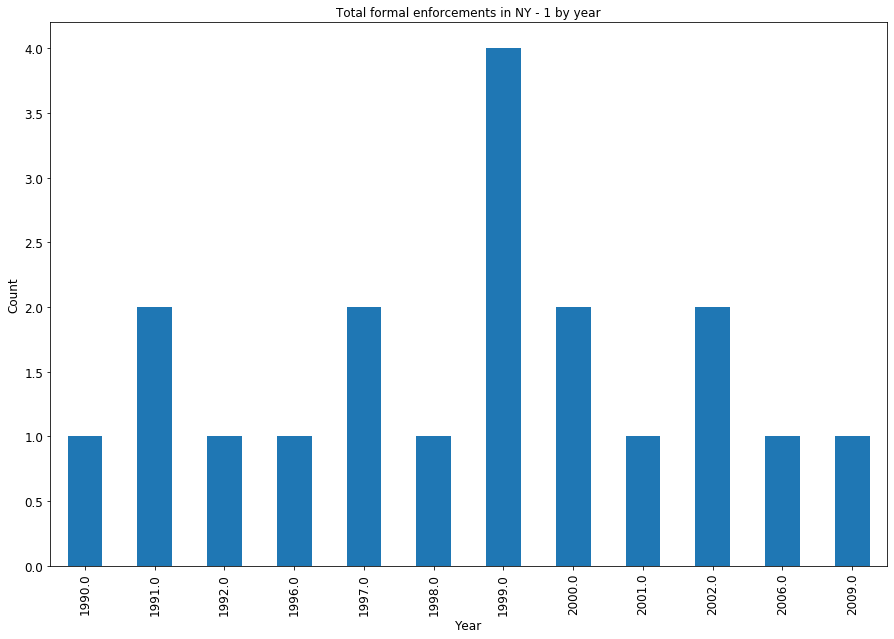

In [39]:
show_plot( my_cd_icis, 'HPV_DAYZERO_DATE', 'HPV_DAYZERO_YEAR', my_state + ' - ' + str( my_cd ), '%m-%d-%Y' )

## Plot the number of violations by year, using the entire state.
Since the number of violations in a single CD may be small, it can be more
interesting to look at the entire state.

                  HPV_DAYZERO_YEAR
HPV_DAYZERO_YEAR                  
1984.0                           1
1986.0                           1
1987.0                           4
1988.0                           2
1989.0                           4
1990.0                           7
1991.0                          12
1992.0                          23
1993.0                          13
1994.0                          19
1995.0                          38
1996.0                          63
1997.0                         139
1998.0                         188
1999.0                         133
2000.0                         129
2001.0                          82
2002.0                         106
2003.0                          49
2004.0                          26
2005.0                          36
2006.0                          70
2007.0                          53
2008.0                          59
2009.0                          26
2010.0                          28
2011.0              

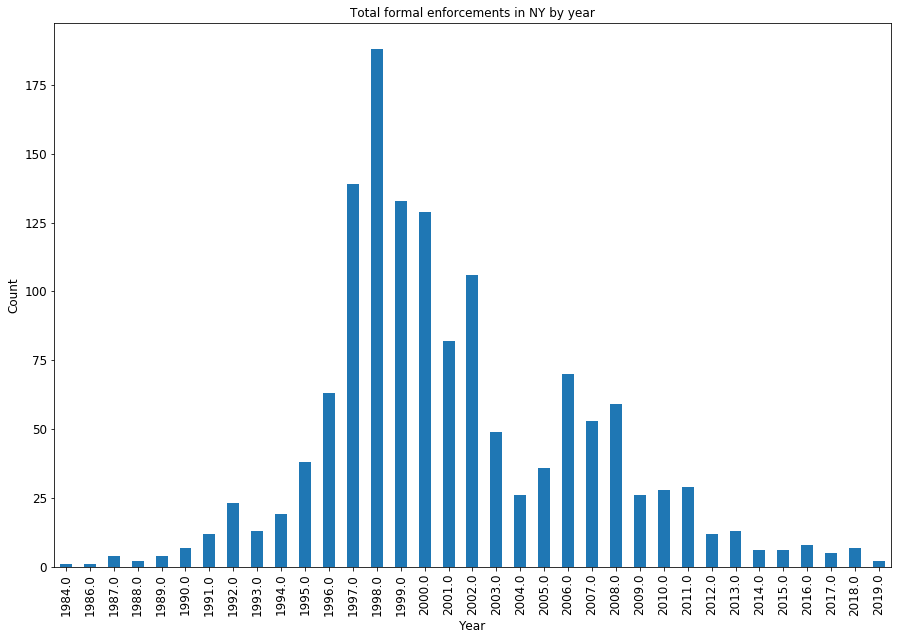

In [40]:
show_plot( icis_data, 'HPV_DAYZERO_DATE', 'HPV_DAYZERO_YEAR', my_state, '%m-%d-%Y' )